In [2]:
%pip install -q transformers datasets scikit-learn torch transformers tf-keras

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%pip install transformers[torch]


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import pandas as pd
import numpy as np
import torch
import time

c:\Users\winne\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Load your separated CSV files
train_df = pd.read_csv('../../../data/train_data.csv')
val_df = pd.read_csv('../../../data/val_data.csv')
test_df = pd.read_csv('../../../data/test_data.csv')

# Map 'Analysis' column (Negative, Neutral, Positive) to numeric labels
label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}

train_df['label'] = train_df['Analysis'].map(label_mapping)
val_df['label'] = val_df['Analysis'].map(label_mapping)
test_df['label'] = test_df['Analysis'].map(label_mapping)


In [6]:
# Ensure text is string and no NaN
train_df['text'] = train_df['text'].astype(str)
val_df['text'] = val_df['text'].astype(str)
test_df['text'] = test_df['text'].astype(str)

train_df['text'] = train_df['text'].fillna("")
val_df['text'] = val_df['text'].fillna("")
test_df['text'] = test_df['text'].fillna("")

In [7]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

# Convert DataFrames to HuggingFace Dataset
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


Map: 100%|██████████| 1938/1938 [00:00<00:00, 11102.73 examples/s]


In [8]:
DistilBert_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to GPU
DistilBert_model = DistilBert_model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    report = classification_report(labels, predictions, target_names=['Negative', 'Neutral', 'Positive'], output_dict=True)
    return {
        'accuracy': report['accuracy'],
        'f1_macro': report['macro avg']['f1-score']
    }

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro"
)

trainer = Trainer(
    model=DistilBert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [10]:
# Initialize time for recording inference time
start = time.time()

# Train the model
trainer.train()

end = time.time()
training_time = end - start

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.564700,0.357038,0.869386,0.858250
2,0.280400,0.311144,0.891585,0.885127
3,0.175100,0.377874,0.899845,0.891540


In [11]:
# Save computation time to CSV
time_df = pd.DataFrame({"distilbert_TrainingTime (s)": [training_time]})
time_df.to_csv("computation_time_distilbert.csv", index=False)

print("Training time: ", training_time, "seconds")
print("Training time is saved")

Training time:  260.50579357147217 seconds
Training time is saved


In [12]:
trainer.save_model("./saved_model_distilbert")
tokenizer.save_pretrained("./saved_model_distilbert")

('./saved_model_distilbert\\tokenizer_config.json',
 './saved_model_distilbert\\special_tokens_map.json',
 './saved_model_distilbert\\vocab.txt',
 './saved_model_distilbert\\added_tokens.json',
 './saved_model_distilbert\\tokenizer.json')

In [13]:
from matplotlib import pyplot as plt 

# Extract logged metrics
logs = trainer.state.log_history

# Separate into lists for plotting
train_loss = []
eval_loss = []
eval_accuracy = []
epochs = []

for log in logs:
    if 'loss' in log and 'epoch' in log:
        train_loss.append(log['loss'])
        epochs.append(log['epoch'])
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])
    if 'eval_accuracy' in log:
        eval_accuracy.append(log['eval_accuracy'])

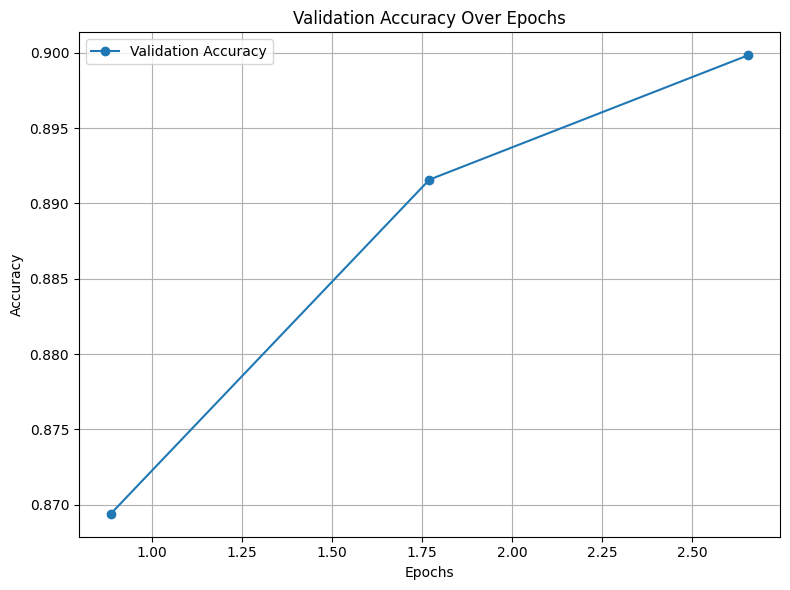

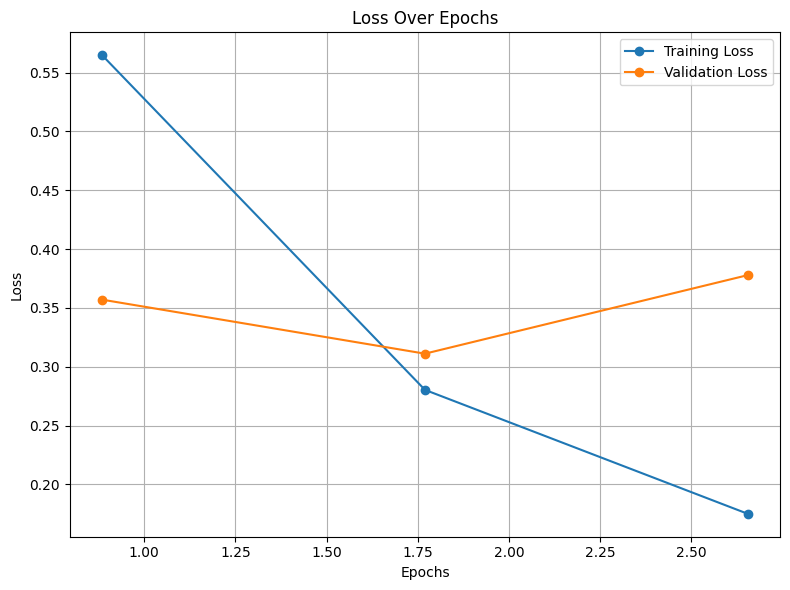

In [14]:
# Accuracy Plot
plt.figure(figsize=(8,6))
plt.plot(epochs[:len(eval_accuracy)], eval_accuracy, label='Validation Accuracy', marker='o')
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_epochs_distilbert.png")
plt.show()

# Loss Plot
plt.figure(figsize=(8,6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs[:len(eval_loss)], eval_loss, label='Validation Loss', marker='o')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_epochs_distilbert.png")
plt.show()